In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [77]:
class NNQS(nn.Module):
    def __init__(self):
        super(NNQS, self).__init__()
        self.fc1_u = nn.Linear(1, 50)
        self.fc2_u = nn.Linear(50, 50)
        self.fc3_u = nn.Linear(50, 1)
        #self.fc4_u = nn.Linear(50, 1)
        #self.fc5_u = nn.Linear(20, 20)
        #self.fc6_u = nn.Linear(20, 1)

    def forward(self, x):
        u = F.softplus(self.fc1_u(x))
        u = F.softplus(self.fc2_u(u))
        #u = F.softplus(self.fc3_u(u))
        #u = torch.tanh(self.fc4_u(u))
        #u = torch.tanh(self.fc5_u(u))
        u = self.fc3_u(u)
        return u

# Initialize model
model = NNQS().to(device)

In [79]:
# Initialize the model
model = NNQS().to(device)
model_save_path = "nnqs_ground_state.pth"

# Load the state dictionary
model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode (optional, for inference)
model.eval()

print("Model parameters loaded successfully.")


Model parameters loaded successfully.


C:\Users\yaman\AppData\Local\Temp\ipykernel_30176\2781409247.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


In [9]:
# Ensure CUDA context initialization
if device.type == 'cuda':
    _ = torch.zeros(1, device=device)  # Force CUDA context initialization

In [81]:
x_min = -10.0
x_max = 10.0
N = 20001
x = torch.linspace(x_min,x_max,N).to(device)
x.requires_grad = True

In [83]:
#Converting x into N x 1 tensor.
x = x.reshape(-1,1)
x

tensor([[-10.0000],
        [ -9.9990],
        [ -9.9980],
        ...,
        [  9.9980],
        [  9.9990],
        [ 10.0000]], device='cuda:0', grad_fn=<ViewBackward0>)

In [85]:
dx = x[1]-x[0]
dx = dx.item()
dx

0.0010004043579101562

In [87]:
model(x)

tensor([[-3.6952e-04],
        [-3.6898e-04],
        [-3.6845e-04],
        ...,
        [ 6.6578e-05],
        [ 6.6809e-05],
        [ 6.7048e-05]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [89]:
w = 2.0
def HpsiH(x,model):
    u = model(x)
    u1 = u.reshape(-1)
    grads = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:,0]
    u_x_grads = torch.autograd.grad(grads, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = u_x_grads[:,0]
    x1 = x.reshape(-1)
    return torch.sum((-u_xx*u1+(w**2)*(x1**2)*(u1**2)))*dx

In [91]:
def normalization(x,model):
    u = model(x)
    return 1000*((torch.sum(u**2)*dx- torch.tensor(1.0))**2)

In [93]:
eta = 0.0001
optimizer = optim.Adam(list(model.parameters()), lr=eta)

In [153]:
for epoch in range(10000):
    E_loss = HpsiH(x,model)
    norm_loss = normalization(x,model)            
    optimizer.zero_grad()
    L_total = E_loss + norm_loss
    
    # Step 3: Backpropagate to compute gradients
    L_total.backward()
    
    # Step 4: Perform the gradient descent step
    optimizer.step()
    
    if epoch%100==99:
        print(f"epochs:{epoch+1} , Loss:{L_total}")

epochs:100 , Loss:2.0020313262939453
epochs:200 , Loss:2.0020248889923096
epochs:300 , Loss:2.002021551132202
epochs:400 , Loss:2.0020129680633545
epochs:500 , Loss:2.0020065307617188
epochs:600 , Loss:2.0020058155059814
epochs:700 , Loss:2.001995086669922
epochs:800 , Loss:2.0019891262054443
epochs:900 , Loss:2.0019826889038086
epochs:1000 , Loss:2.0019774436950684
epochs:1100 , Loss:2.001971960067749
epochs:1200 , Loss:2.0019664764404297
epochs:1300 , Loss:2.001960277557373
epochs:1400 , Loss:2.0025057792663574
epochs:1500 , Loss:2.001948833465576
epochs:1600 , Loss:2.0036256313323975
epochs:1700 , Loss:2.0019373893737793
epochs:1800 , Loss:2.00193190574646
epochs:1900 , Loss:2.0019259452819824
epochs:2000 , Loss:2.0019924640655518
epochs:2100 , Loss:2.0019145011901855
epochs:2200 , Loss:2.001909017562866
epochs:2300 , Loss:2.0019030570983887
epochs:2400 , Loss:2.0019032955169678
epochs:2500 , Loss:2.0018930435180664
epochs:2600 , Loss:2.001887798309326
epochs:2700 , Loss:2.001882553

In [95]:
u_pred = model(x).reshape(-1)

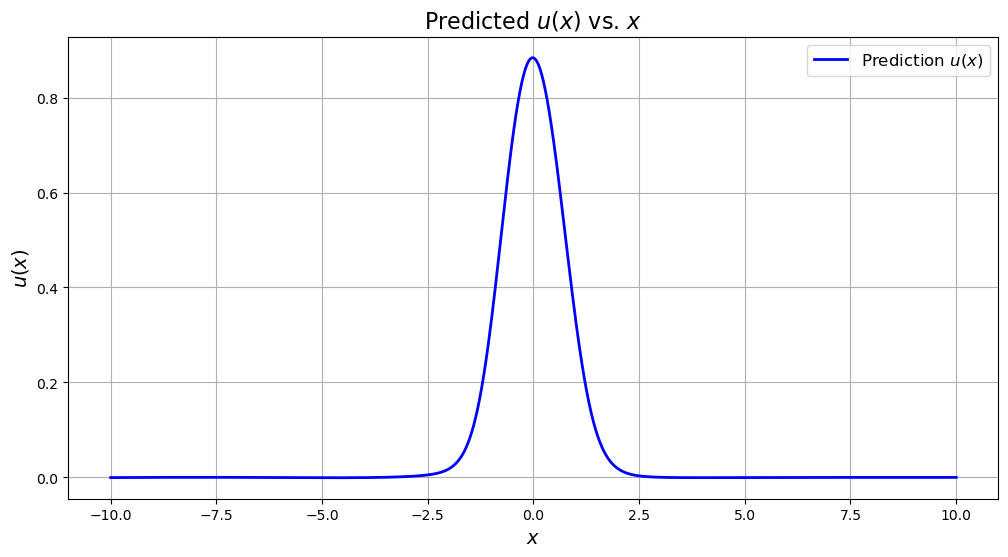

In [97]:
u_pred = model(x).reshape(-1)
# Assuming u_pred is already converted to a numpy array
u_plot = u_pred.detach().cpu().numpy()

# Create x_array
x_array = np.linspace(x_min, x_max, N)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x_array, u_plot, label='Prediction $u(x)$', color='blue', linewidth=2)

# Add labels, title, and legend
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$u(x)$', fontsize=14)
plt.title('Predicted $u(x)$ vs. $x$', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()


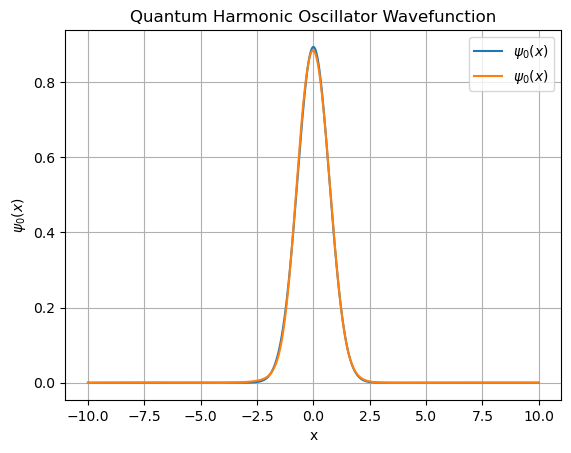

In [99]:
import numpy as np
from scipy.special import hermite, factorial

def psi_n(X, n, m, omega, hbar):
    """
    Calculate the wavefunction psi_n(x) for the quantum harmonic oscillator.

    Parameters:
    x : float or ndarray
        Position where the wavefunction is evaluated.
    n : int
        Quantum number (n = 0, 1, 2, ...).
    m : float
        Mass of the particle.
    omega : float
        Angular frequency of the oscillator.
    hbar : float
        Reduced Planck's constant.

    Returns:
    float or ndarray
        Value of the wavefunction at position x.
    """
    # Pre-factor
    norm_factor = (1 / np.sqrt(2**n * factorial(n))) * (m * omega / (np.pi * hbar))**0.25

    # Exponential term
    exp_factor = np.exp(-m * omega * X**2 / (2 * hbar))

    # Hermite polynomial
    H_n = hermite(n)
    hermite_term = H_n(np.sqrt(m * omega / hbar) * X)

    # Wavefunction
    psi = norm_factor * exp_factor * hermite_term

    return psi

# Example usage
m = 1.0      # Mass of the particle
omega = 2.0  # Angular frequency
hbar = 1.0   # Reduced Planck's constant
X = np.linspace(-10, 10, 20001)  # Position array
n = 0        # Quantum number

# Calculate psi_n(x) for the given n
wavefunction = psi_n(X, n, m, omega, hbar)

# Optional: Plotting
import matplotlib.pyplot as plt

plt.plot(X, wavefunction, label=f"$\psi_{n}(x)$")
plt.plot(X, u_plot, label=f"$\psi_{n}(x)$")

plt.title("Quantum Harmonic Oscillator Wavefunction")
plt.xlabel("x")
plt.ylabel(f"$\psi_{n}(x)$")
plt.legend()
plt.grid()
plt.show()


In [418]:
# Specify the path to save the model parameters
model_save_path = "nnqs_ground_state.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model parameters saved to {model_save_path}")


Model parameters saved to nnqs_ground_state.pth


In [117]:
class NNES(nn.Module):
    def __init__(self):
        super(NNES, self).__init__()
        self.fc1_u = nn.Linear(1, 50)
        self.fc2_u = nn.Linear(50, 50)
        self.fc3_u = nn.Linear(50, 1)
        #self.fc4_u = nn.Linear(50, 1)
        #self.fc5_u = nn.Linear(20, 20)
        #self.fc6_u = nn.Linear(20, 1)

    def forward(self, x):
        u = F.softplus(self.fc1_u(x))
        u = F.softplus(self.fc2_u(u))
        #u = F.softplus(self.fc3_u(u))
        #u = torch.tanh(self.fc4_u(u))
        #u = torch.tanh(self.fc5_u(u))
        u = self.fc3_u(u)
        return u

# Initialize model
model_excited = NNES().to(device)

In [119]:
u_ground = model(x)
u_grad = torch.autograd.grad(u_ground, x, grad_outputs=torch.ones_like(u_ground), create_graph=True)[0]
u_gradgrad = torch.autograd.grad(u_grad, x, grad_outputs=torch.ones_like(u_ground), create_graph=True)[0]
u_ground_xx = u_gradgrad[:,0]
u_ground_xx

tensor([-0.0002, -0.0002, -0.0002,  ...,  0.0002,  0.0002,  0.0002],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [121]:
u_g = u_ground.clone().detach()
u_g_xx = u_ground_xx.clone().detach()

In [123]:
w = 2.0
def HpsiH(x,model_excited):
    u_exc_crude = model_excited(x)
    cosine = ((torch.sum(u_exc_crude*u_g))/(torch.sum(u_g**2)))
    u_exc = u_exc_crude - cosine*u_g
    grads = torch.autograd.grad(u_exc_crude, x, grad_outputs=torch.ones_like(u_exc_crude), create_graph=True)[0]
    u_x_grads = torch.autograd.grad(grads, x, grad_outputs=torch.ones_like(u_exc_crude), create_graph=True)[0]
    u_xx = u_x_grads[:,0]
    x1 = x.reshape(-1)
    u_xx_exc = u_xx - cosine*u_g_xx
    u_exc_shaped = u_exc.reshape(-1)
    return torch.sum((-u_xx_exc*u_exc_shaped+(w**2)*(x1**2)*(u_exc_shaped**2)))*dx

In [125]:
def normalize(x,model_excited):
    u_exc_crude = model_excited(x)
    cosine = ((torch.sum(u_exc_crude*u_g))/(torch.sum(u_g**2)))
    u_exc = u_exc_crude - cosine*u_g
    return 1000*((torch.sum(u_exc**2)*dx - torch.tensor(1.0))**2)

In [135]:
eta = 0.001
optimizer2 = optim.Adam(list(model_excited.parameters()), lr=eta)

In [115]:
# Ensure CUDA context initialization
if device.type == 'cuda':
    _ = torch.zeros(1, device=device)  # Force CUDA context initialization

In [137]:
for epoch in range(10000):
    E_loss = HpsiH(x,model_excited)
    norm_loss = normalize(x,model_excited)         
    optimizer2.zero_grad()
    Loss_total = E_loss + norm_loss
    #Loss_total = norm_loss

    # Step 3: Backpropagate to compute gradients
    Loss_total.backward()
    
    # Step 4: Perform the gradient descent step
    optimizer2.step()
    
    if epoch%100==99:
        print(f"epochs:{epoch+1} , Loss:{Loss_total}")

epochs:100 , Loss:141.72560119628906
epochs:200 , Loss:21.90268898010254
epochs:300 , Loss:9.916679382324219
epochs:400 , Loss:8.045440673828125
epochs:500 , Loss:7.185462474822998
epochs:600 , Loss:6.7399749755859375
epochs:700 , Loss:6.5077362060546875
epochs:800 , Loss:6.389211654663086
epochs:900 , Loss:6.329634666442871
epochs:1000 , Loss:6.295368194580078
epochs:1100 , Loss:6.274993419647217
epochs:1200 , Loss:6.263519287109375
epochs:1300 , Loss:6.24783182144165
epochs:1400 , Loss:6.236163139343262
epochs:1500 , Loss:6.224745750427246
epochs:1600 , Loss:6.2145562171936035
epochs:1700 , Loss:6.200082778930664
epochs:1800 , Loss:6.232457160949707
epochs:1900 , Loss:6.172752857208252
epochs:2000 , Loss:6.158708095550537
epochs:2100 , Loss:6.145150184631348
epochs:2200 , Loss:6.133858680725098
epochs:2300 , Loss:6.120461463928223
epochs:2400 , Loss:6.113396167755127
epochs:2500 , Loss:6.099785327911377
epochs:2600 , Loss:6.097632884979248
epochs:2700 , Loss:6.08289098739624
epochs:2

In [139]:
u_exc_crude = model_excited(x)
u_exc = u_exc_crude - ((torch.sum(u_exc_crude*u_g))/(torch.sum(u_g**2)))*u_ground
torch.sum(u_exc**2)*dx

tensor(1.0005, device='cuda:0', grad_fn=<MulBackward0>)

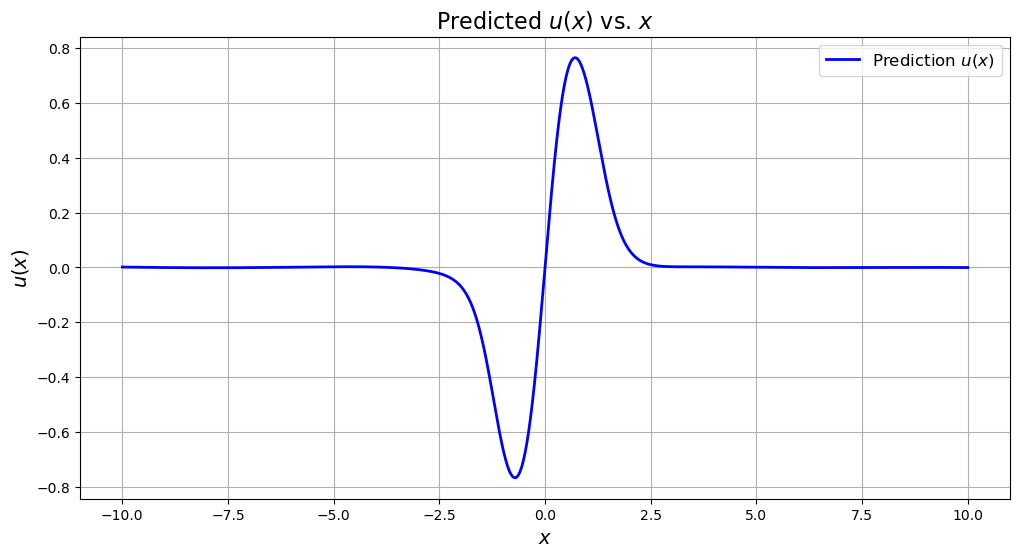

In [141]:
# Assuming u_pred is already converted to a numpy array
u_plot_excited = u_exc.reshape(-1).clone().detach().cpu().numpy()

# Create x_array
x_array = np.linspace(x_min, x_max, N)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x_array, u_plot_excited, label='Prediction $u(x)$', color='blue', linewidth=2)

# Add labels, title, and legend
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$u(x)$', fontsize=14)
plt.title('Predicted $u(x)$ vs. $x$', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()

In [125]:
torch.sum((-u_xx*u_exc_shaped+(w**2)*(x1**2)*(u_exc_shaped**2)))*dx

NameError: name 'u_xx' is not defined

In [104]:
import torch
import torch.optim as optim

def HpsiH(x, model_excited, u_ground, u_ground_xx, dx, w=2.0):
    # Detach x and create a new one that requires grad
    x_calc = x.detach().clone().requires_grad_(True)
    
    u_exc_crude = model_excited(x_calc)
    cosine = ((torch.sum(u_exc_crude*u_ground))/(torch.sum(u_ground**2)))
    u_exc = u_exc_crude - cosine*u_ground
    
    # First derivative
    grads = torch.autograd.grad(u_exc_crude, x_calc, 
                               grad_outputs=torch.ones_like(u_exc_crude), 
                               create_graph=True)[0]
    u_x = grads[:,0]
    
    # Second derivative
    u_x_grads = torch.autograd.grad(u_x.sum(), x_calc, 
                                   create_graph=True)[0]
    u_xx = u_x_grads[:,0]
    
    x1 = x_calc.reshape(-1)
    u_xx_exc = u_xx - cosine*u_ground_xx
    u_exc_shaped = u_exc.reshape(-1)
    
    return torch.sum((-u_xx_exc*u_exc_shaped+(w**2)*(x1**2)*(u_exc_shaped**2)))*dx

def normalize(x, model_excited, u_ground, dx):
    # Create new x tensor for this calculation
    x_calc = x.detach().clone().requires_grad_(True)
    
    u_exc_crude = model_excited(x_calc)
    cosine = ((torch.sum(u_exc_crude*u_ground))/(torch.sum(u_ground**2)))
    u_exc = u_exc_crude - cosine*u_ground
    return 1000*((torch.sum(u_exc**2)*dx - torch.tensor(1.0))**2)

def train_model(x, model_excited, u_ground, u_ground_xx, dx, num_epochs=10000, eta=0.01):
    optimizer2 = optim.Adam(list(model_excited.parameters()), lr=eta)
    
    for epoch in range(num_epochs):
        optimizer2.zero_grad()
        
        # Calculate losses with fresh computation graphs
        E_loss = HpsiH(x, model_excited, u_ground, u_ground_xx, dx)
        norm_loss = normalize(x, model_excited, u_ground, dx)
        Loss_total = E_loss + norm_loss
        
        # Backward pass
        Loss_total.backward()  # No need for retain_graph now
        
        # Optimization step
        optimizer2.step()
        
        if epoch%100 == 99:
            print(f"epochs:{epoch+1} , Loss:{Loss_total.item()}")
            
    return model_excited

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [108]:
import torch
import torch.optim as optim

def HpsiH(x, model_excited, u_ground, u_ground_xx, dx, w=2.0):
    u_exc_crude = model_excited(x)
    cosine = ((torch.sum(u_exc_crude*u_ground))/(torch.sum(u_ground**2)))
    u_exc = u_exc_crude - cosine*u_ground
    
    grads = torch.autograd.grad(u_exc_crude, x, 
                               grad_outputs=torch.ones_like(u_exc_crude), 
                               create_graph=True)[0]
    u_x = grads[:,0]
    
    u_x_grads = torch.autograd.grad(grads, x, 
                                   grad_outputs=torch.ones_like(u_exc_crude), 
                                   create_graph=True)[0]
    u_xx = u_x_grads[:,0]
    
    x1 = x.reshape(-1)
    u_xx_exc = u_xx - cosine*u_ground_xx
    u_exc_shaped = u_exc.reshape(-1)
    
    return torch.sum((-u_xx_exc*u_exc_shaped+(w**2)*(x1**2)*(u_exc_shaped**2)))*dx

def normalize(x, model_excited, u_ground, dx):
    with torch.set_grad_enabled(True):  # Ensure we can compute gradients
        u_exc_crude = model_excited(x)
        cosine = ((torch.sum(u_exc_crude*u_ground))/(torch.sum(u_ground**2)))
        u_exc = u_exc_crude - cosine*u_ground
        return 1000*((torch.sum(u_exc**2)*dx - torch.tensor(1.0))**2)

def train_model(x, model_excited, u_ground, u_ground_xx, dx, num_epochs=10000, eta=0.01):
    optimizer2 = optim.Adam(list(model_excited.parameters()), lr=eta)
    
    for epoch in range(num_epochs):
        # Forward pass with a fresh computation graph
        with torch.set_grad_enabled(True):
            E_loss = HpsiH(x, model_excited, u_ground, u_ground_xx, dx)
            norm_loss = normalize(x, model_excited, u_ground, dx)
            Loss_total = E_loss + norm_loss
        
        # Zero gradients before backward pass
        optimizer2.zero_grad()
        
        # Backward pass
        Loss_total.backward()
        
        # Optimization step
        optimizer2.step()
        
        if epoch%100 == 99:
            print(f"epochs:{epoch+1} , Loss:{Loss_total.item()}")
    
    return model_excited

In [110]:
train_model(x, model_excited, u_ground, u_ground_xx, dx, num_epochs=10000, eta=0.01)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [136]:
torch.sum(u_ground**2)*0.001

tensor(0.9985, device='cuda:0', grad_fn=<MulBackward0>)